# Credit Card Fraud Detection Mini Project
I have made this credit card fraud detection project using the dataset available on kaggle. From my observations from dataset, I found that this dataset is highly imbalanced dataset where fraud class contribute to only around 0.01 % and rest above are Legal class. <br>

I have used the machine learning classification algorithms like Naive Bayes, Logistic Regression and Random Forest for predicting the class and finding the similarities between different dataset. I have also tried to used autoencoder for better understanding the similarites and finding hidden relations between dataset.



In [141]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, f1_score, precision_recall_curve, accuracy_score, precision_score, roc_auc_score,
                             recall_score,precision_recall_fscore_support, auc, roc_curve)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import matplotlib.gridspec as gridspec
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 18, 10
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [142]:
df = pd.read_csv('creditcard.csv')

print(df.head(10))
print(df.info())

   Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0
5   2.0 -0.425966  0.960523  1.141109  ...  0.253844  0.081080    3.67      0
6   4.0  1.229658  0.141004  0.045371  ...  0.034507  0.005168    4.99      0
7   7.0 -0.644269  1.417964  1.074380  ... -1.206921 -1.085339   40.80      0
8   7.0 -0.894286  0.286157 -0.113192  ...  0.011747  0.142404   93.20      0
9   9.0 -0.338262  1.119593  1.044367  ...  0.246219  0.083076    3.68      0

[10 rows x 31 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Co

In [143]:
fraud = df[df['Class'] == 1] 
valid = df[df['Class'] == 0] 
outlierFraction = len(fraud)/float(len(valid)) 
print(outlierFraction) 
print('Fraud Cases: {}'.format(len(data[data['Class'] == 1]))) 
print('Valid Transactions: {}'.format(len(data[data['Class'] == 0]))) 


0.0017304750013189597
Fraud Cases: 492
Valid Transactions: 284315


In [158]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [159]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

# Plotting the pie chart of classes

Pie chart of classes


Text(0, 0.5, '')

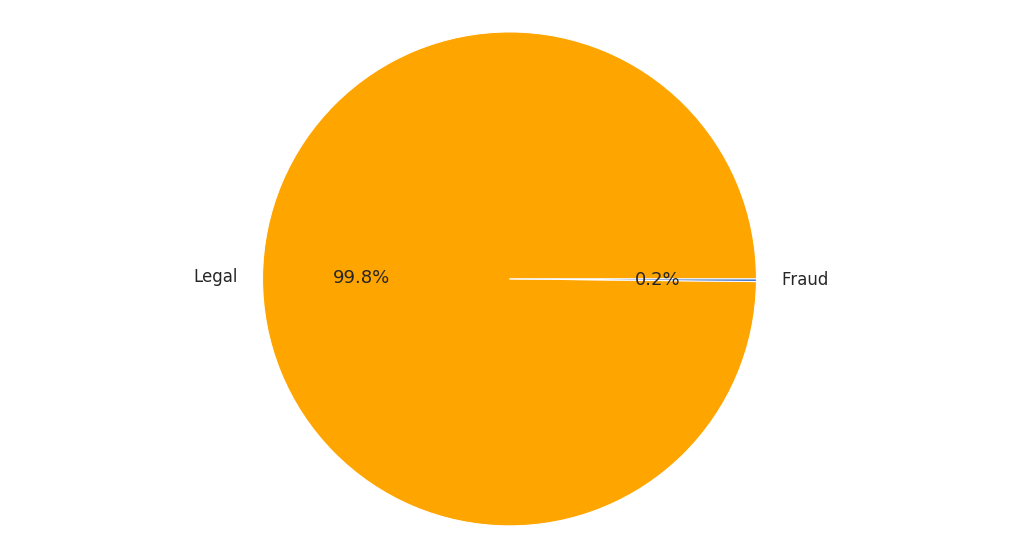

In [144]:
print("Pie chart of classes")
fig, axis = plt.subplots(1,1)
axis.pie(df['Class'].value_counts(), labels=['Legal','Fraud'], autopct='%1.1f%%', colors=['orange','b'])
plt.axis('equal')
plt.ylabel('')

In [145]:
df.isnull().values.any() # No null value is present in the dataset

False

Text(0, 0.5, 'Frequency')

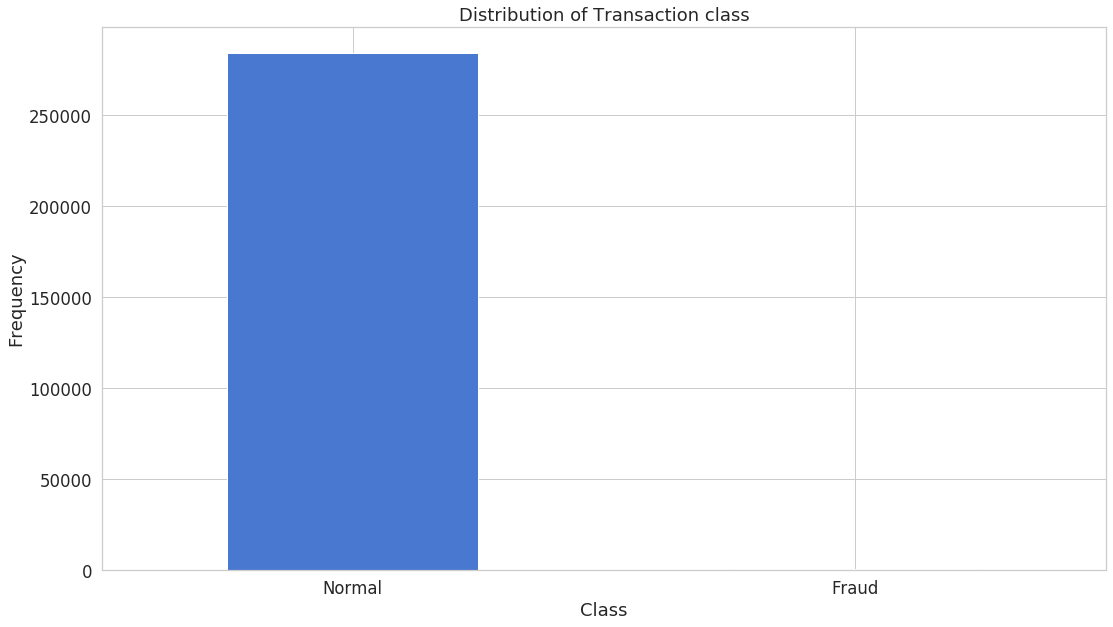

In [146]:
class_count.plot(kind = 'bar', rot = 0)
plt.title("Distribution of Transaction class")
plt.xlabel("Class")
plt.xticks(range(2), LABELS)
plt.ylabel("Frequency")

# Plotting Relevant features to see trends in dataset

<h2>1. Plotting Time Feature. </h2>

Time variable
284802    47.996111
284803    47.996389
284804    47.996667
284805    47.996667
284806    47.997778
Name: Time_Hr, dtype: float64


Text(0, 0.5, '# transactions')

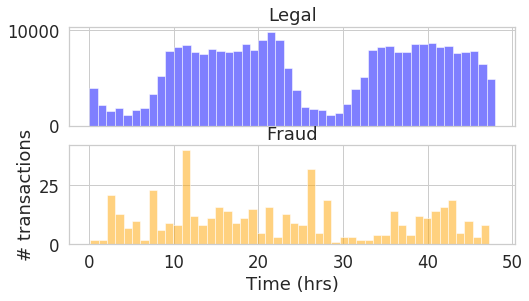

In [147]:
print("Time variable")
df["Time_Hr"] = df["Time"]/3600 # converting to hours
print(df["Time_Hr"].tail(5))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(8,4))
ax1.hist(df.Time_Hr[df.Class==0],bins=48,color='blue',alpha=0.5)
ax1.set_title('Legal')
ax2.hist(df.Time_Hr[df.Class==1],bins=48,color='orange',alpha=0.5)
ax2.set_title('Fraud')
plt.xlabel('Time (hrs)')
plt.ylabel('# transactions')

"Time" feature shows that rate of transactions is picking up during day time. But number of transactions have almost similar dependence on time of the day for both the classes. <br>
I feel that this will not contribute much to distinguish between the two classes.

# Plotting more relevant features

Text(0, 0.5, '# transactions')

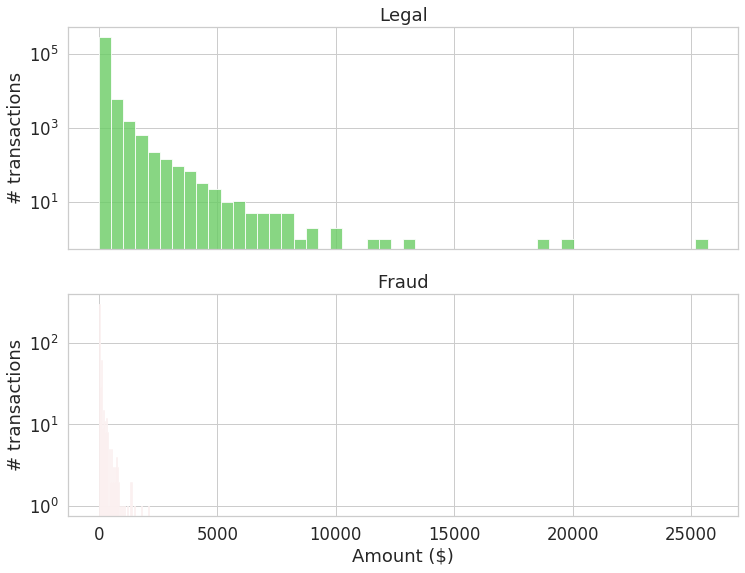

In [121]:
fig, (ax3,ax4) = plt.subplots(2,1, figsize = (12,9), sharex = True)
ax3.hist(df.Amount[df.Class==0],bins=50,color='g',alpha=0.8)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Legal') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(df.Amount[df.Class==1],bins=50,color='r',alpha=0.8)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('Amount ($)')
ax4.set_ylabel('# transactions')

From the above graph it is visible that all the transactions more than 5000 comes under legal transaction. I'll standardize the values of the 'Amount' feature using StandardScalar

In [122]:
df['New_Scaled_Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df = df.drop(['Amount'],axis=1)

# let us check correlations and shapes of those 25 principal components.
Features V1, V2, ... V28 are the principal components obtained with PCA.

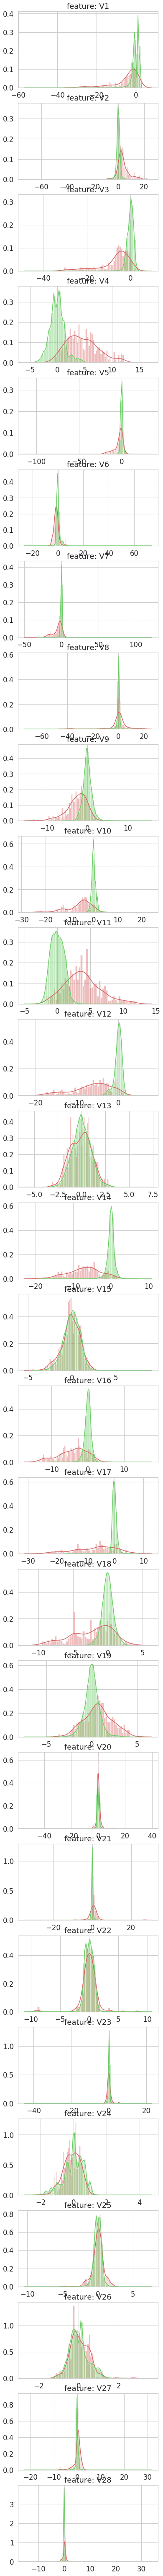

In [135]:
gs = gridspec.GridSpec(28, 1)
plt.figure(figsize=(6,28*4))
for i, col in enumerate(df[df.iloc[:,0:28].columns]):
    ax5 = plt.subplot(gs[i])
    sns.distplot(df[col][df.Class == 1], bins=50, color='r')
    sns.distplot(df[col][df.Class == 0], bins=50, color='g')
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(col))
plt.show()

# Plotting the Correlation Matrix
The correlation matrix graphically gives us an idea of how features correlate with each other and can help us predict what are the features that are most relevant for the prediction.

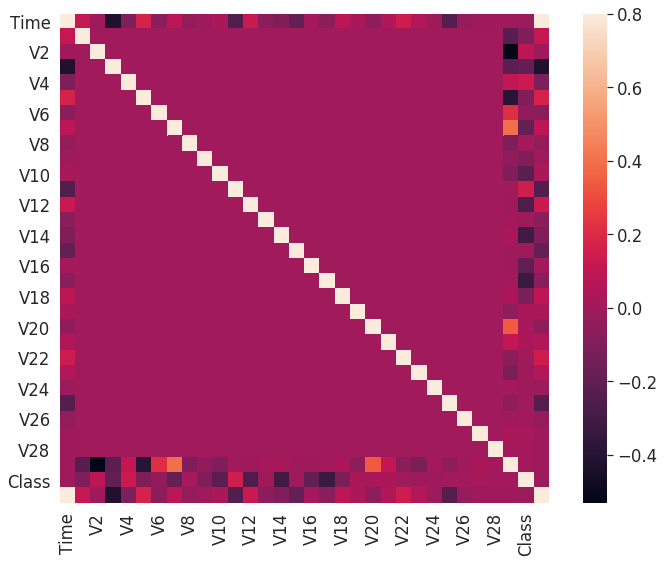

In [155]:
correlation_matrix = df.corr()
fig = plt.figure(figsize =(12,9))
sns.heatmap(correlation_matrix, vmax = .8, square = True) 
plt.show()

In the correlation matrix we can clearly see that most of the features do not correlate to other features but there are some features that either has a positive or a negative correlation with each other. For example, V2 and V5 are highly negatively correlated with the feature called Amount. We also see some correlation with V20 and Amount.

<h3>Writing the predictions, split_data, and scores function based on various classifiers.</h3>


In [126]:
def split_data(df, drop_list):
    df = df.drop(drop_list,axis=1)
    print(df.columns)
    y = df['Class'].values #target
    X = df.drop(['Class'],axis=1).values #features
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

    print("train-set size: ", len(y_train),
      "\ntest-set size: ", len(y_test))
    print("fraud cases in test-set: ", sum(y_test))
    return X_train, X_test, y_train, y_test

In [123]:
def get_predictions(X_train, Y_train, X_test, classifier):
    clf = classifier
    clf.fit(X_train,Y_train)
    y_pred = clf.predict(X_test)
    # Finding predicted probabilities: y_pred_prob
    y_pred_prob = clf.predict_proba(X_test)
    return y_pred, y_pred_prob

In [150]:
def print_scores(y_test,y_pred,y_pred_prob):
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred))
    print("precision score: ", precision_score(y_test,y_pred))
    print("f1 score: ", f1_score(y_test,y_pred))
    print("accuracy score: ", accuracy_score(y_test,y_pred))

In [151]:
# Case 1 - Do not drop anything
dropping_list = []
X_train, X_test, y_train, y_test = split_data(df, dropping_list)
y_pred, y_pred_prob = get_predictions(X_train, y_train, X_test, GaussianNB())
print_scores(y_test,y_pred,y_pred_prob)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Time_Hr'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
test-set confusion matrix:
 [[56502   362]
 [   36    62]]
recall score:  0.6326530612244898
precision score:  0.14622641509433962
f1 score:  0.2375478927203065
accuracy score:  0.9930128857835048


In [152]:
# Case-NB-2 : drop some of principle components that have similar distributions in above plots
dropping_list = ['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, dropping_list)
y_pred, y_pred_prob = get_predictions(X_train, y_train, X_test, GaussianNB())
print_scores(y_test,y_pred,y_pred_prob)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11',
       'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Amount', 'Class',
       'Time_Hr'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
test-set confusion matrix:
 [[56584   280]
 [   35    63]]
recall score:  0.6428571428571429
precision score:  0.1836734693877551
f1 score:  0.28571428571428575
accuracy score:  0.9944699975422211


# Using Logistic Regression for predicting outputs

In [153]:
dropping_list = []
X_train, X_test, y_train, y_test = split_data(df, dropping_list)
y_pred, y_pred_prob = get_predictions(X_train, y_train, X_test, LogisticRegression())
print_scores(y_test,y_pred,y_pred_prob)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11',
       'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Amount', 'Class',
       'Time_Hr'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
test-set confusion matrix:
 [[56825    39]
 [   42    56]]
recall score:  0.5714285714285714
precision score:  0.5894736842105263
f1 score:  0.5803108808290155
accuracy score:  0.9985779993679997


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [154]:
# Case-NB-2 : drop some of principle components that have similar distributions in above plots
dropping_list = ['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, dropping_list)
y_pred, y_pred_prob = get_predictions(X_train, y_train, X_test, LogisticRegression())
print_scores(y_test,y_pred,y_pred_prob)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11',
       'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Amount', 'Class',
       'Time_Hr'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
test-set confusion matrix:
 [[56825    39]
 [   42    56]]
recall score:  0.5714285714285714
precision score:  0.5894736842105263
f1 score:  0.5803108808290155
accuracy score:  0.9985779993679997


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Random Forest Classifier For prediction


In [156]:
dropping_list = [] #Case 1 Didn't drop anything
X_train, X_test, y_train, y_test = split_data(df, dropping_list)
y_pred, y_pred_prob = get_predictions(X_train, y_train, X_test, RandomForestClassifier())
print_scores(y_test,y_pred,y_pred_prob)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Time_Hr'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
test-set confusion matrix:
 [[56862     2]
 [   23    75]]
recall score:  0.7653061224489796
precision score:  0.974025974025974
f1 score:  0.8571428571428571
accuracy score:  0.9995611109160493


In [157]:
# Case-2 : drop some of principle components that have similar distributions
dropping_list = ['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, dropping_list)
y_pred, y_pred_prob = get_predictions(X_train, y_train, X_test, RandomForestClassifier())
print_scores(y_test,y_pred,y_pred_prob)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11',
       'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Amount', 'Class',
       'Time_Hr'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
test-set confusion matrix:
 [[56862     2]
 [   22    76]]
recall score:  0.7755102040816326
precision score:  0.9743589743589743
f1 score:  0.8636363636363635
accuracy score:  0.9995786664794073


# Predictions using autoencoders 
Separating the X and Y value<br>
Dividing the data into inputs parameters and outputs value format

In [82]:
# dividing the X and the Y from the dataset 
X = data.drop(['Class'], axis = 1) 
Y = data["Class"] 
print(X.shape) 
print(Y.shape) 
# getting just the values for the sake of processing  
# (its a numpy array with no columns) 
xData = X.values 
yData = Y.values 

(284807, 29)
(284807,)


In [85]:
xTrain, xTest, yTrain, yTest = train_test_split(xData, yData, test_size = 0.2, random_state = 42) 
rfc = RandomForestClassifier() 
rfc.fit(xTrain, yTrain) 
# predictions 
yPred = rfc.predict(xTest) 

In [93]:
n_outliers = len(fraud) 
n_errors = (yPred != yTest).sum() 
print("The model used is Random Forest classifier") 
  
acc = accuracy_score(yTest, yPred) 
print("The accuracy is {}".format(acc)) 
  
prec = precision_score(yTest, yPred) 
print("The precision is {}".format(prec)) 
  
rec = recall_score(yTest, yPred) 
print("The recall is {}".format(rec)) 
  
f1 = f1_score(yTest, yPred) 
print("The F1-Score is {}".format(f1)) 

The model used is Random Forest classifier
The accuracy is 0.9995786664794073
The precision is 0.9743589743589743
The recall is 0.7755102040816326
The F1-Score is 0.8636363636363635


We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let’s look at the two types of transactions:



count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

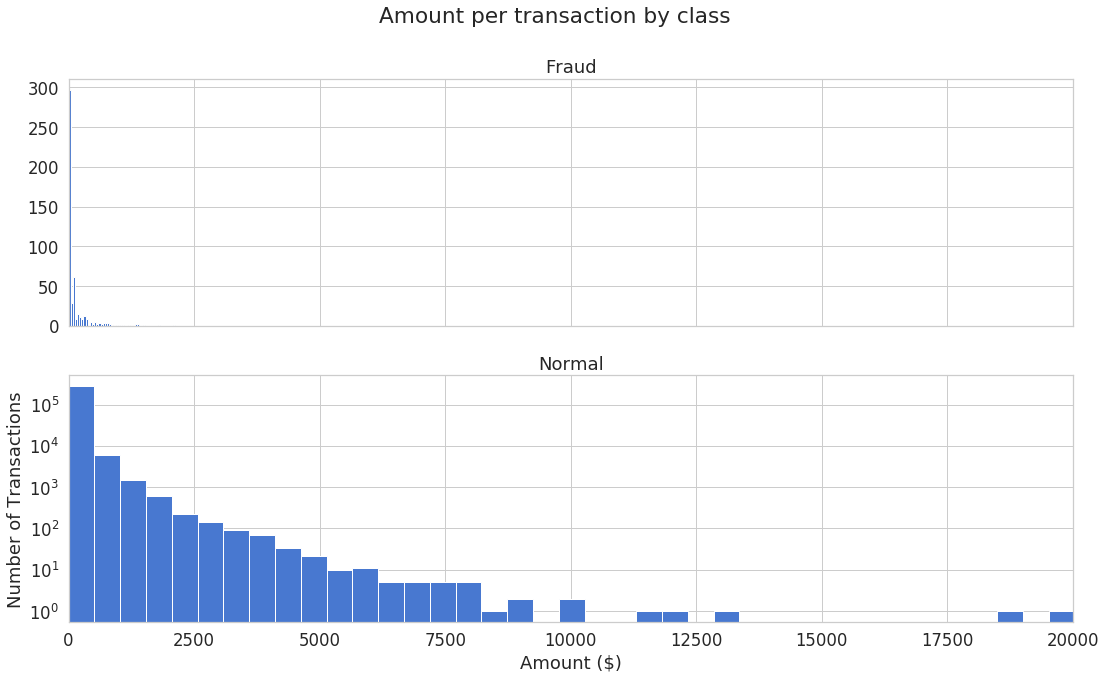

In [160]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

# Do fraudulent transactions occur more often during certain time?

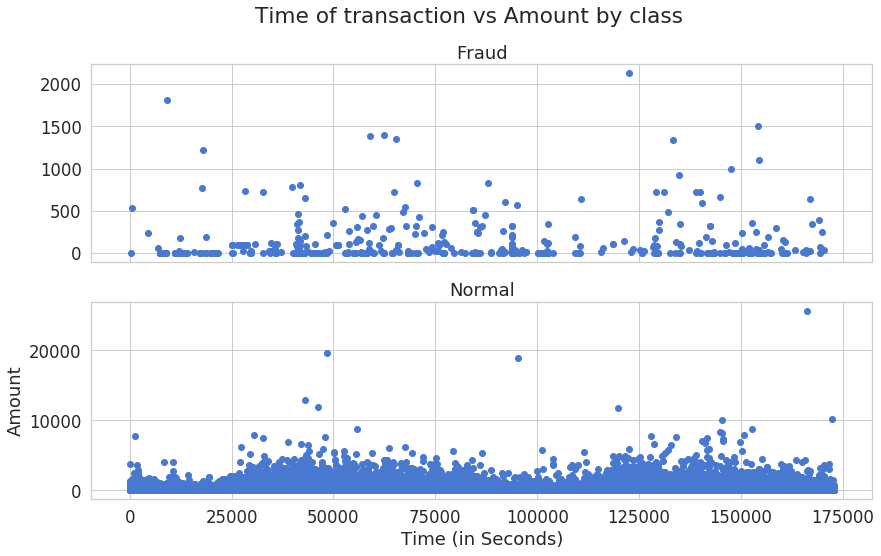

In [28]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# Autoencoders
Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. Puzzling? Definitely was for me, the first time I heard it. <br>

More specifically, let’s take a look at Autoencoder Neural Networks. This autoencoder tries to learn to approximate the following identity function:

\textstyle f_{W,b}(x) \approx xf 
W,b
​	
 (x)≈x

While trying to do just that might sound trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called undercomplete.



# Reconstruction error
We optimize the parameters of our Autoencoder model in such way that a special kind of error - reconstruction error is minimized. In practice, the traditional squared error is often used:

In [29]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis = 1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

<h6>Training our Autoencoder is gonna be a bit different from what we are used to. Let’s say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing </h6>

In [36]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values

In [38]:
print(X_train.shape)

print(X_test.shape)

(227451, 29)
(56962, 29)


# Building the Model
Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training: <br>
https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c

In [39]:
X_train.shape[1]

29

In [40]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [41]:
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Let’s train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally, the training progress will be exported in a format that TensorBoard understands.

In [43]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 10s 46us/step - loss: 0.8158 - accuracy: 0.5876 - val_loss: 0.7961 - val_accuracy: 0.6427
Epoch 2/100
227451/227451 [==============================] - 9s 40us/step - loss: 0.7524 - accuracy: 0.6592 - val_loss: 0.7784 - val_accuracy: 0.6669
Epoch 3/100
227451/227451 [==============================] - 9s 41us/step - loss: 0.7414 - accuracy: 0.6663 - val_loss: 0.7704 - val_accuracy: 0.6711
Epoch 4/100
227451/227451 [==============================] - 9s 40us/step - loss: 0.7368 - accuracy: 0.6674 - val_loss: 0.7674 - val_accuracy: 0.6671
Epoch 5/100
227451/227451 [==============================] - 9s 41us/step - loss: 0.7332 - accuracy: 0.6707 - val_loss: 0.7659 - val_accuracy: 0.6721
Epoch 6/100
227451/227451 [==============================] - 9s 40us/step - loss: 0.7309 - accuracy: 0.6738 - val_loss: 0.7634 - val_accuracy: 0.6771
Epoch 7/100
227451/227451 [=====================

Epoch 55/100
227451/227451 [==============================] - 9s 39us/step - loss: 0.7196 - accuracy: 0.6938 - val_loss: 0.7562 - val_accuracy: 0.6959
Epoch 56/100
227451/227451 [==============================] - 9s 39us/step - loss: 0.7194 - accuracy: 0.6954 - val_loss: 0.7542 - val_accuracy: 0.6989
Epoch 57/100
227451/227451 [==============================] - 9s 39us/step - loss: 0.7194 - accuracy: 0.6950 - val_loss: 0.7547 - val_accuracy: 0.7006
Epoch 58/100
227451/227451 [==============================] - 9s 39us/step - loss: 0.7193 - accuracy: 0.6948 - val_loss: 0.7585 - val_accuracy: 0.6843
Epoch 59/100
227451/227451 [==============================] - 9s 39us/step - loss: 0.7195 - accuracy: 0.6950 - val_loss: 0.7550 - val_accuracy: 0.6929
Epoch 60/100
227451/227451 [==============================] - 9s 39us/step - loss: 0.7190 - accuracy: 0.6953 - val_loss: 0.7557 - val_accuracy: 0.6966
Epoch 61/100
227451/227451 [==============================] - 9s 39us/step - loss: 0.7195 - ac

In [44]:
autoencoder = load_model('model.h5')

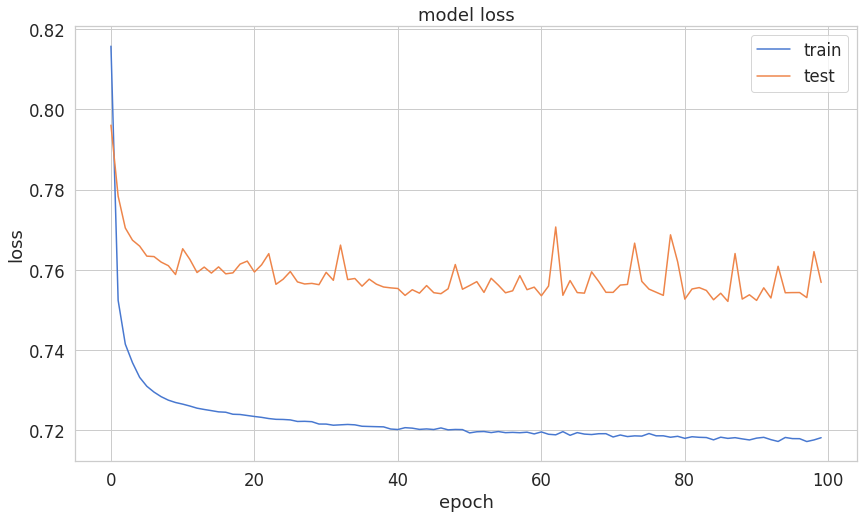

In [45]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough

In [52]:
predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis = 1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'true_class': y_test})

In [53]:
error_df.describe()

,Reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.742937,0.001720
std,3.448056,0.041443
min,0.061164,0.000000
25%,0.245590,0.000000
50%,0.388714,0.000000
75%,0.613752,0.000000
max,265.932191,1.000000


# Plotting reconstruction error without fraud

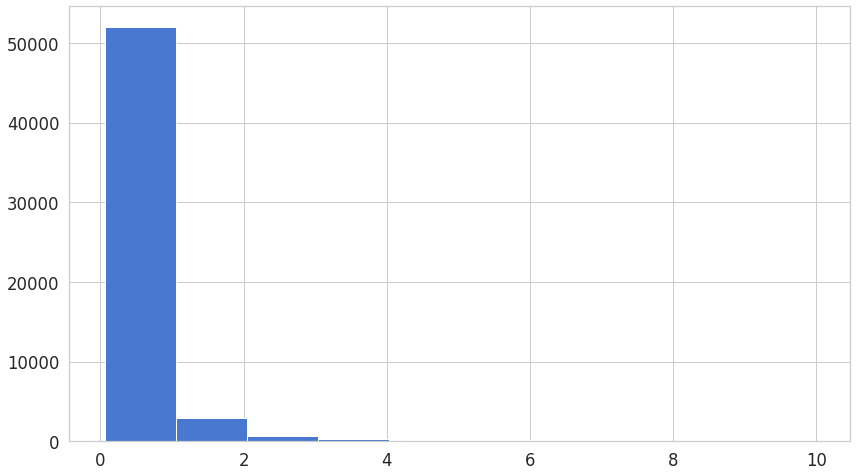

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['Reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.Reconstruction_error.values, bins=10)

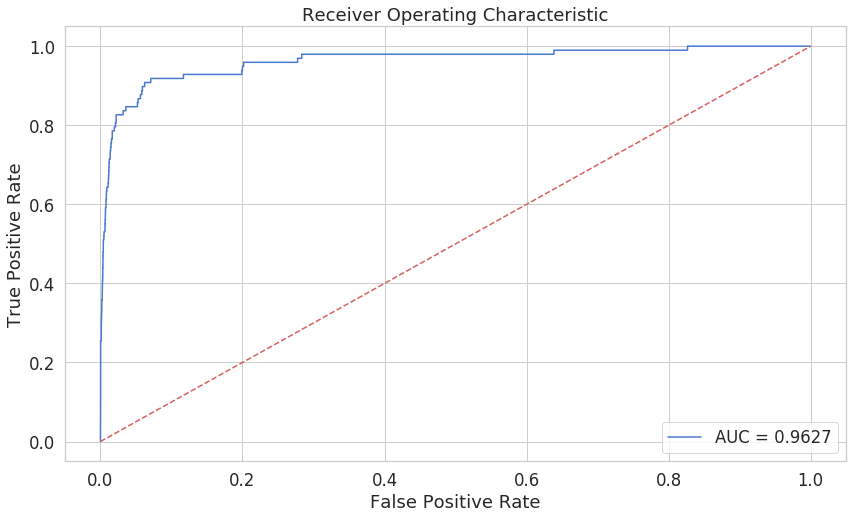

In [88]:

fpr, tpr, threshold = roc_curve(error_df.true_class, error_df.Reconstruction_error)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

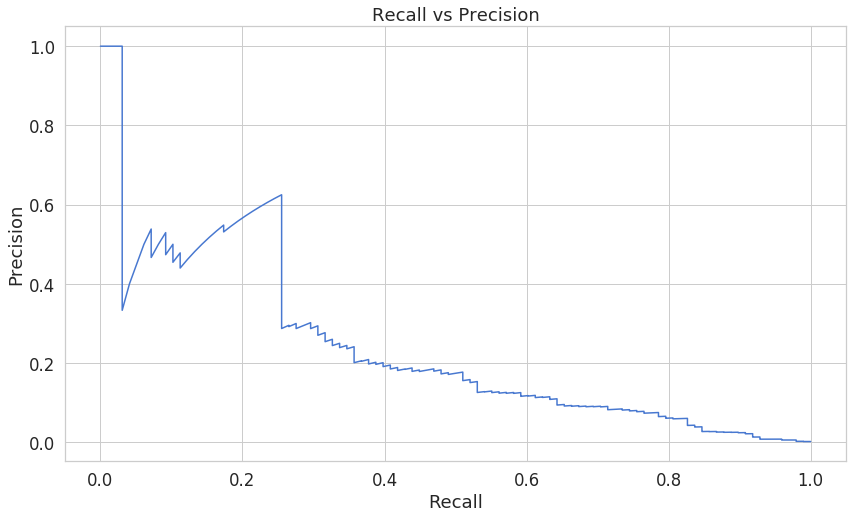

In [59]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.Reconstruction_error)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

In [61]:
print(precision)
precision.shape

[0.00208046 0.00205927 0.00205932 ... 1.         1.         1.        ]


(46576,)

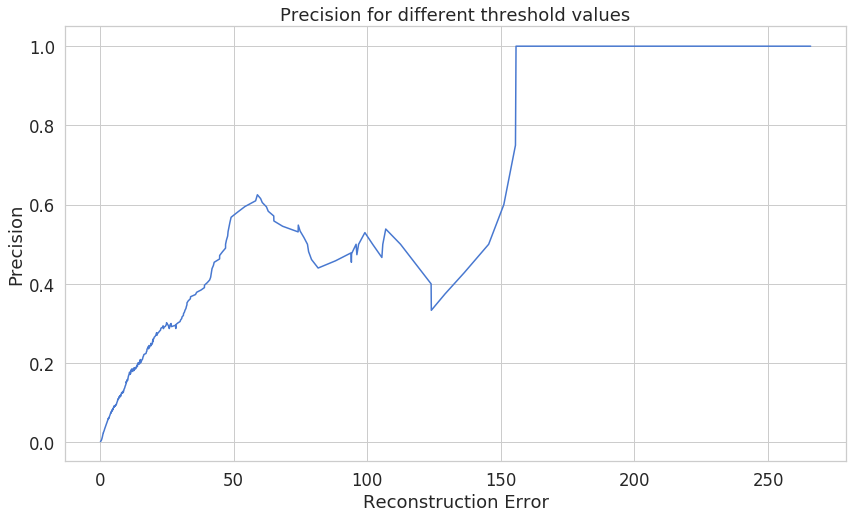

In [64]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Reconstruction Error')
plt.ylabel('Precision')
plt.show()

<h4>We can see that as the reconstruction error increases our precision rises as well.</h4>

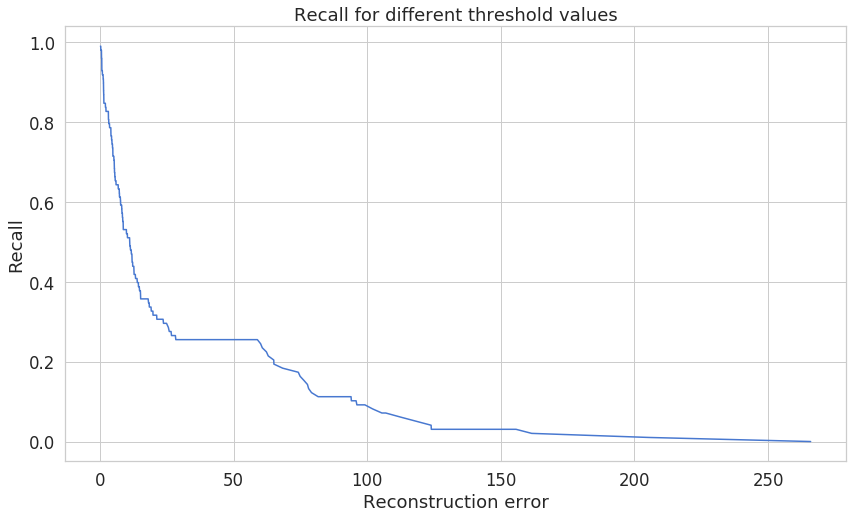

In [65]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

<h4> Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases. </h4>

# Prediction
Our model is a bit different this time. It doesn’t know how to predict new values. But we don’t need that.<br> 
In order to predict whether or not a new/unseen transaction is normal or fraudulent, we’ll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we’ll mark it as a fraud (since our model should have a low error on normal transactions).

0         Reconstruction_error  true_class
49906               0.764070           0
29474               0.293581           0
276481              0.413981           0
278846              0.176290           0
101565              0.990018           0
...                      ...         ...
75723               0.695356           0
252263              0.205821           0
221246              0.497301           0
81910               0.149061           0
59490               1.563862           0

[56864 rows x 2 columns]
1         Reconstruction_error  true_class
43428              81.651074           1
116404              5.561088           1
215984              9.906505           1
249239              1.287924           1
146790              1.184751           1
...                      ...         ...
152223             96.146973           1
6903               18.201529           1
276864              5.447346           1
199896              6.025952           1
248971              3.58106

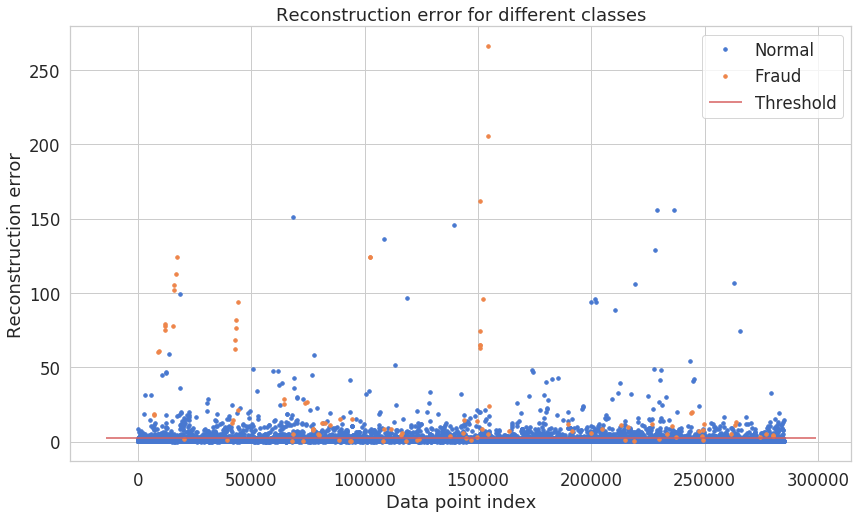

In [76]:
threshold = 2.5
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
#     print(name, group)
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

# Confusion Matrix 

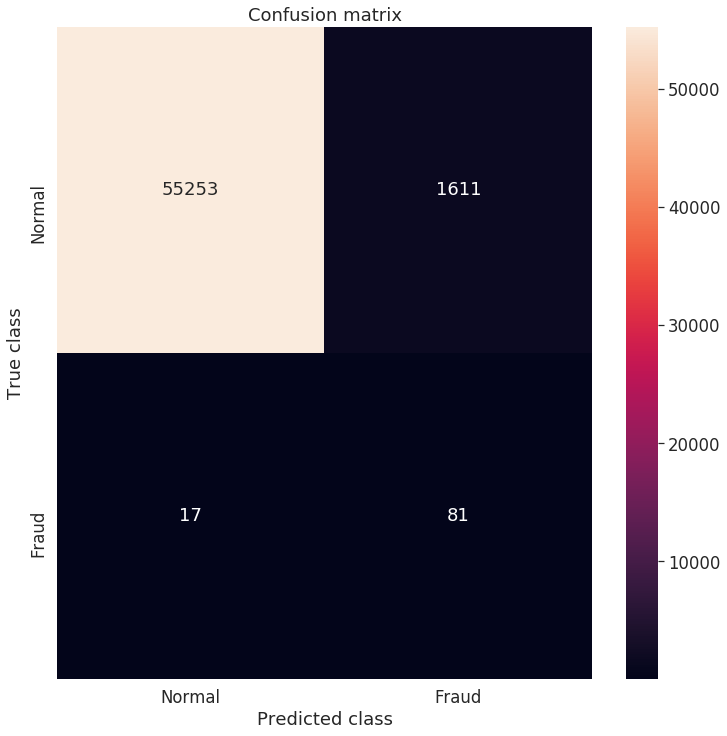

In [77]:
y_pred = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Getting the model ready for deployment

In [ ]:
import pickle
with open('Credit_Card_Model.pkl', 'wb') as file: